### Import & Setup

In [1]:
import vtk
from vtk.util import numpy_support
import os
import numpy
import matplotlib.pyplot as plt

### Tools

We're gonna use this function to quickly convert a `vtkImageData` array to a `numpy.ndarray`

In [2]:
def vtkImageToNumPy(image, pixelDims):
    pointData = image.GetPointData()
    arrayData = pointData.GetArray(0)
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    ArrayDicom = ArrayDicom.reshape(pixelDims, order='F')
    
    return ArrayDicom

We're gonna use this function to embed a still image of a VTK render

### DICOM Input

Load and read-in the DICOM files

In [3]:
PathDicom = "./vhm_head/"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

Read in meta-data

In [4]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]
print(ConstPixelDims)

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

[512, 512, 245]


It seems that the `vtkDICOMImageReader` automatically rescales the DICOM data to give the Hounsfield Units. If it didn't then this is how you would go about rescaling it

In [5]:
#shiftScale = vtk.vtkImageShiftScale()
#shiftScale.SetScale(reader.GetRescaleSlope())
#shiftScale.SetShift(reader.GetRescaleOffset())
#shiftScale.SetInputConnection(reader.GetOutputPort())
#shiftScale.Update()

# In the next cell you would simply get the output with 'GetOutput' from 'shiftScale' instead of 'reader'

Visualize

(512, 512, 245)


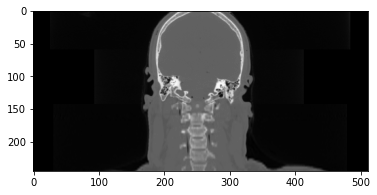

In [5]:
ArrayDicom = vtkImageToNumPy(reader.GetOutput(), ConstPixelDims)
print(ArrayDicom.shape)
plt.set_cmap(plt.gray())
plt.imshow(ArrayDicom[:, 256, :].T)
plt.show()

Use the `vtkImageThreshold` to clean all soft-tissue from the image data

In [6]:
threshold = vtk.vtkImageThreshold ()
threshold.SetInputConnection(reader.GetOutputPort())
threshold.ThresholdByLower(420)  # remove all soft tissue
threshold.ReplaceInOn()
threshold.SetInValue(0)  # set all values below 400 to 0
threshold.ReplaceOutOn()
threshold.SetOutValue(1)  # set all values above 400 to 1
threshold.Update()

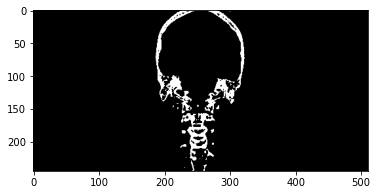

In [7]:
ArrayDicom = vtkImageToNumPy(threshold.GetOutput(), ConstPixelDims)
plt.imshow(ArrayDicom[:-1, 256, :].T)
plt.show()

Use the `vtkDiscreteMarchingCubes` class to extract the surface

In [8]:
%%time
dmc = vtk.vtkDiscreteMarchingCubes()
dmc.SetInputConnection(threshold.GetOutputPort())
dmc.GenerateValues(1, 1, 1)
dmc.Update()

CPU times: total: 688 ms
Wall time: 684 ms


In [10]:
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(dmc.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1.0, 1.0, 1.0)

renderer_window = vtk.vtkRenderWindow()
renderer_window.AddRenderer(renderer) 
renderer_interactor = vtk.vtkRenderWindowInteractor()
renderer_interactor.SetRenderWindow(renderer_window)
renderer.SetBackground(1,1,1)
renderer_window.SetSize(1024, 768)

renderer_interactor.Initialize()
renderer_window.Render()
renderer_interactor.Start()
